In [1]:
import pandas as pd
import parquet
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import itertools
import keras_tuner as kt
from sklearn.metrics import precision_score, accuracy_score, recall_score, classification_report
from keras import backend as K
from tensorflow.keras.saving import get_custom_objects
from imblearn.over_sampling import ADASYN, SMOTEN, RandomOverSampler
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve, auc


plot_ = True
DD = "/mnt/g/WSL/downloaded_ml_data/" 

plot_ = False

2023-11-21 15:10:04.350425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 15:10:07.135433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Exploratory Data Analysis and pre-processing

In [2]:
cctrans = pd.read_parquet(f"{DD}credit_card_dataset_fraud_detect/credit_card_transaction_data_de.parquet")
cccards = pd.read_parquet(f"{DD}credit_card_dataset_fraud_detect/sd254_cards_de.parquet")
ccusers = pd.read_parquet(f"{DD}credit_card_dataset_fraud_detect/credit_card_users_de.parquet")

print("user data-",ccusers.columns,"\n transaction data-", cctrans.columns,"\n card data-", cccards.columns)


user data- Index(['Person', 'Current Age', 'Retirement Age', 'Birth Year', 'Birth Month',
       'Gender', 'Address', 'Apartment', 'City', 'State', 'Zipcode',
       'Latitude', 'Longitude', 'Per Capita Income - Zipcode',
       'Yearly Income - Person', 'Total Debt', 'FICO Score',
       'Num Credit Cards'],
      dtype='object') 
 transaction data- Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?'],
      dtype='object') 
 card data- Index(['User', 'CARD INDEX', 'Card Brand', 'Card Type', 'Card Number',
       'Expires', 'CVV', 'Has Chip', 'Cards Issued', 'Credit Limit',
       'Acct Open Date', 'Year PIN last Changed', 'Card on Dark Web'],
      dtype='object')


In [3]:
cctrans.loc[cctrans['Is Fraud?']=='Yes']
cctrans['Fraud'] = cctrans['Is Fraud?'].apply(lambda x:1 if x=='Yes' else 0).astype('bool')
assert cctrans.loc[cctrans['Is Fraud?']=='Yes'].shape[0] == cctrans['Fraud'].sum()
hr = cctrans.copy()['Time'].apply(lambda x: x.split(":")[0])
min = cctrans.copy()['Time'].apply(lambda x: x.split(":")[1])

# print(hr)
cctrans['Hour'] = hr
cctrans['Minute'] = min
cctrans['Hour_decimal'] = hr.astype("float") + (min.astype("float")/60.)
cctrans['Amount'] = cctrans['Amount'].str.strip("$")

ccusers.loc[:,'User'] = ccusers.index

In [35]:
# if plot_:
onlyfrauds = cctrans.loc[cctrans.Fraud==1]
print(onlyfrauds.shape)
onlyfrauds.sort_values("Hour_decimal", inplace=True)
onlyfraudsbymerchant = onlyfrauds.groupby('Merchant State')['Fraud'].count().reset_index()
# print(onlyfraudsbymerchant)

fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(12,4))
ax.scatter(onlyfrauds['Hour_decimal'],
           onlyfrauds['Amount'].astype("float"),
           marker='o',s=0.5,color='orange',zorder=-1,ls='None',
           label='All Fraud',
          rasterized=True)
# scax = ax.scatter(onlyfrauds['Hour_decimal'],onlyfrauds['Amount'].astype("float"),c='black',alpha=0.25, marker='.')
# plt.colorbar(scax)
rollmed = onlyfrauds.rolling(window=50)
ax.plot(rollmed['Hour_decimal'].mean(), rollmed['Amount'].median(), c='red', lw=3, label='Frauds trend')

onlylegits = cctrans[cctrans['Fraud'] == 0].sort_values("Hour_decimal")
ax.scatter(onlylegits['Hour_decimal'], 
           onlylegits['Amount'].astype("float"),
           marker='o',s=0.1,edgecolor='black',facecolor='None',zorder=-2,ls='None',
           label='All Legit',
          rasterized=True)
rollmed = onlylegits.rolling(window=1000)
ax.plot(rollmed['Hour_decimal'].mean(), rollmed['Amount'].median(), c='cyan',lw=1, label='Legits trend')
ax.set_ylim(-500,500)
ax.set_xlim(0,24)
ax.set_ylabel('Transaction Amount  $', fontsize=14)
ax.set_xlabel("Hours [24HR]", fontsize=14)
ax.legend(loc='upper left',framealpha=1.,markerscale=10)
plt.savefig("/mnt/g/WSL/wsl_ml_figures/ccfraud_hour_decimal_amount_trend.png",bbox_inches='tight', dpi=150)
plt.close()

(8412, 19)


/tmp/ipykernel_2910/1185425064.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onlyfrauds.sort_values("Hour_decimal", inplace=True)


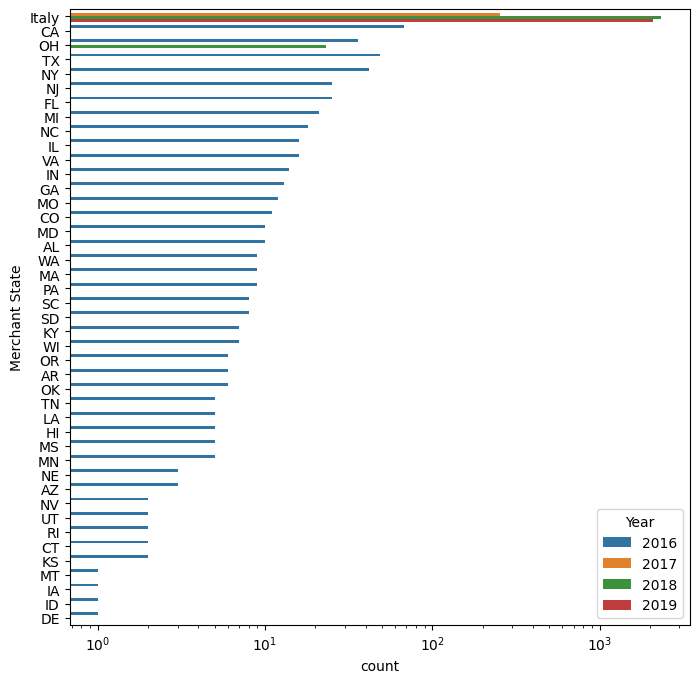

In [57]:
# if plot_:
fig,ax = plt.subplots(figsize=(8,8))
sns.countplot(data=onlyfrauds, 
              y='Merchant State', 
              order=onlyfrauds['Merchant State'].value_counts().index,
              ax=ax,
              hue='Year',
              lw=2
             )
ax.set_xscale('log')
# print(onlyfrauds['Merchant City'].value_counts().head(20))

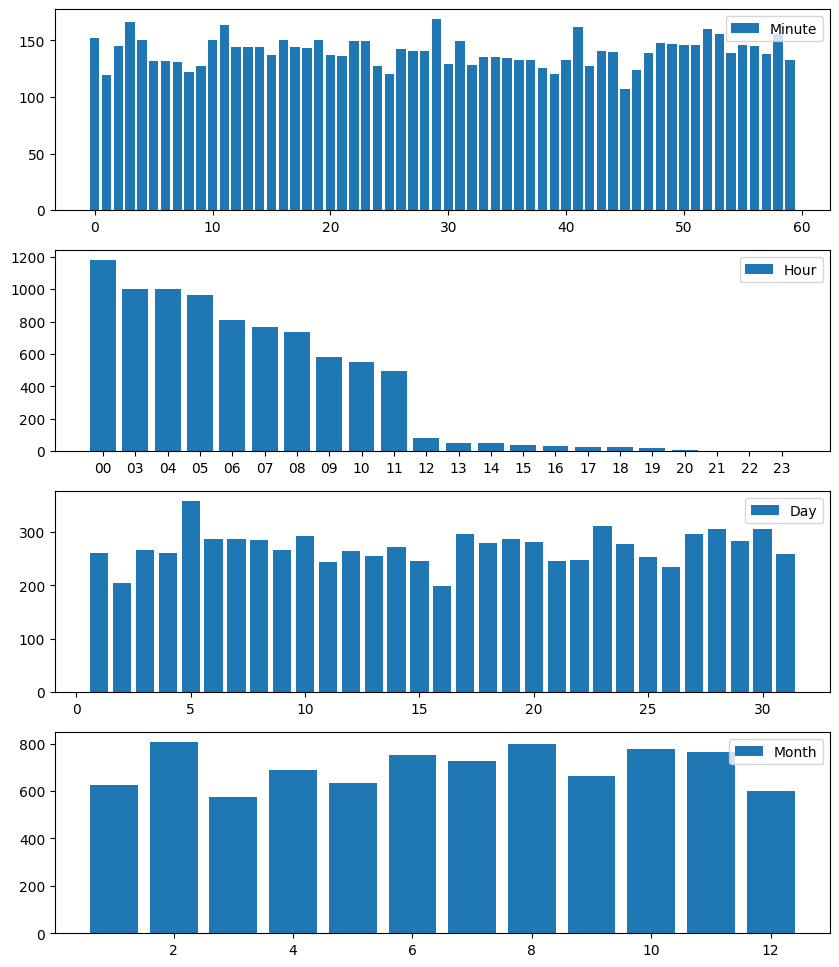

In [58]:
# if plot_:
fig,ax = plt.subplots(nrows=4, ncols=1, figsize=(10,12))
ax[0].bar(onlyfrauds['Minute'].unique().astype('int'),
          onlyfrauds['Minute'].value_counts(),
          label='Minute')
ax[1].bar(onlyfrauds['Hour'].unique(),
          onlyfrauds['Hour'].value_counts(),
          label='Hour')
ax[2].bar(onlyfrauds['Day'].unique(),
          onlyfrauds['Day'].value_counts(),
          label='Day')
ax[3].bar(onlyfrauds['Month'].unique(),
          onlyfrauds['Month'].value_counts(),
          label='Month')
[ax[ii].legend() for ii in range(4)];

In [59]:
apartments = np.ones(ccusers.shape[0]).astype('int32')
apartments[ccusers['Apartment'].isna()] = 0
ccusers['Apartment?'] = apartments

homes = np.zeros(ccusers.shape[0]).astype('int32')
homes[~ccusers['Apartment'].isna()] = 1
ccusers['Home?'] = homes

# fig,ax = plt.subplots(figsize=(8,4))

In [60]:
### does each user ONLY have one type of card (amex, visa, etc) or do they have multiples (2x visa, 4x mastercard)

byuser_ = cccards.groupby("User")
for ii, usr in enumerate(byuser_.groups):
    indgroup = byuser_.get_group(usr)
    brand_counts = Counter(indgroup['Card Brand'])
    print(Counter(indgroup['CARD INDEX']))
    if np.any(np.array(list(brand_counts.values())) > 1):
        print("USERS CAN HAVE MORE THAN ONE TYPE OF CC")
        break

Counter({0: 1, 1: 1, 2: 1, 3: 1, 4: 1})
USERS CAN HAVE MORE THAN ONE TYPE OF CC


In [4]:
transactions_to_drop = []

type_check = {'Amex':'3', 'Visa':'4', 'Mastercard':'5', 'Discover':'6'}

cctrans['CARD INDEX'] = cctrans['Card']

cctrans_aug = cctrans.merge(cccards, on=['User','CARD INDEX'])

cctrans_aug = cctrans_aug.merge(ccusers, on='User')
print(cctrans_aug.shape, cctrans_aug.columns)
cctrans = []

(6877837, 49) Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?', 'Fraud', 'Hour', 'Minute', 'Hour_decimal',
       'CARD INDEX', 'Card Brand', 'Card Type', 'Card Number', 'Expires',
       'CVV', 'Has Chip', 'Cards Issued', 'Credit Limit', 'Acct Open Date',
       'Year PIN last Changed', 'Card on Dark Web', 'Person', 'Current Age',
       'Retirement Age', 'Birth Year', 'Birth Month', 'Gender', 'Address',
       'Apartment', 'City', 'State', 'Zipcode', 'Latitude', 'Longitude',
       'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
       'FICO Score', 'Num Credit Cards'],
      dtype='object')


In [62]:
in_apt = cctrans_aug.loc[cctrans_aug['Apartment?'] == 1]
print(Counter(in_apt['Fraud']))
in_apt = []

not_in_apt = cctrans_aug.loc[cctrans_aug['Apartment?'] == 0]
print(Counter(not_in_apt['Fraud']))
not_in_apt = []


Counter({False: 1876068, True: 2008})
Counter({False: 4993357, True: 6404})


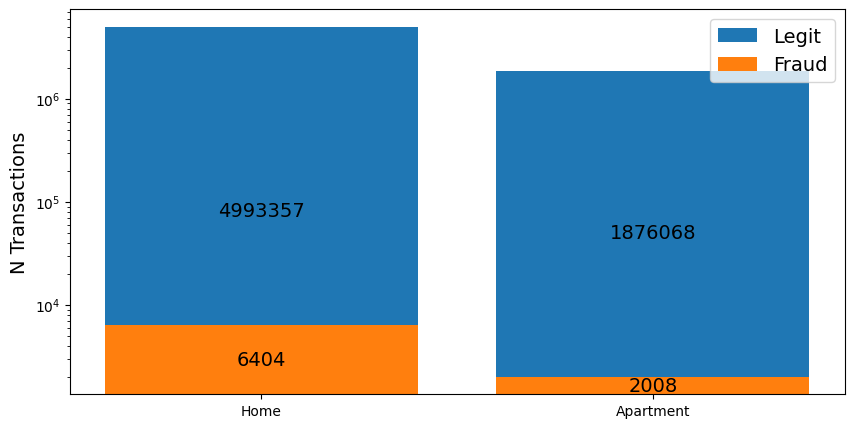

In [63]:
apt_legit = 1876068
apt_fraud = 2008
home_legit = 4993357
home_fraud = 6404


fig,ax = plt.subplots(figsize=(10,5))
blegit = ax.bar(['Home','Apartment'],[home_legit,apt_legit],zorder=0, align='center', label='Legit')
bfraud = ax.bar(['Home','Apartment'],[home_fraud,apt_fraud],zorder=1, label='Fraud')
ax.legend(fontsize=14)
ax.bar_label(blegit,fmt='%.0f',fontsize=14, label_type='center')
ax.bar_label(bfraud, fontsize=14, label_type='center')
# ax.text('Home',home_legit,f'Legit Transactions\n {home_legit}',
#         verticalalignment='top',color='white', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel("N Transactions", fontsize=14)
# ax.set_xlabel("Domicile Type",fontsize=14)

plt.savefig("/mnt/g/WSL/wsl_ml_figures/ccfraud_domicile_fraud_plot.png",bbox_inches='tight')

In [6]:
legits = cctrans_aug['Fraud'] == 0
frauds = cctrans_aug['Fraud'] == 1

fig,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(cctrans_aug.loc[legits], x='Year',ax=ax, cumulative=True,label='Transaction YR (Legit)', color='C0')
sns.kdeplot(cctrans_aug.loc[frauds], x='Year',ax=ax, cumulative=True,label='Transaction YR (Fraud)', color='C0',ls='--')
sns.kdeplot(cctrans_aug.loc[legits], x='Year PIN last Changed',ax=ax,ls='-', cumulative=True, label='YR last PIN change (Legit)', color='C1')
sns.kdeplot(cctrans_aug.loc[frauds], x='Year PIN last Changed',ax=ax,ls='--', cumulative=True, label='YR last PIN change (Fraud)', color='C1')

ax.legend(fontsize=14, loc='upper left')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("CDF",fontsize=14)

plt.savefig("/mnt/g/WSL/wsl_ml_figures/ccfraud_pin_change_year_cdf.png",bbox_inches='tight',dpi=150)
plt.close()
print(np.sum(cctrans_aug['Year'].astype('int') < cctrans_aug['Year PIN last Changed'].astype('int')) / cctrans_aug.shape[0])

0.020324122249480468


In [65]:
#### stripping dollar signs and un-needed strings from values
cctrans_aug['Amount'] = cctrans_aug['Amount'].str.strip("$").astype("float32")
cctrans_aug['Per Capita Income - Zipcode'] = cctrans_aug['Per Capita Income - Zipcode'].str.strip('$').astype('float32')
cctrans_aug['Total Debt'] = cctrans_aug['Total Debt'].str.strip("$").astype('float32')
cctrans_aug['Credit Limit'] = cctrans_aug['Credit Limit'].str.strip("$").astype('float32')
cctrans_aug['Yearly Income - Person'] = cctrans_aug['Yearly Income - Person'].str.strip("$").astype('float32')



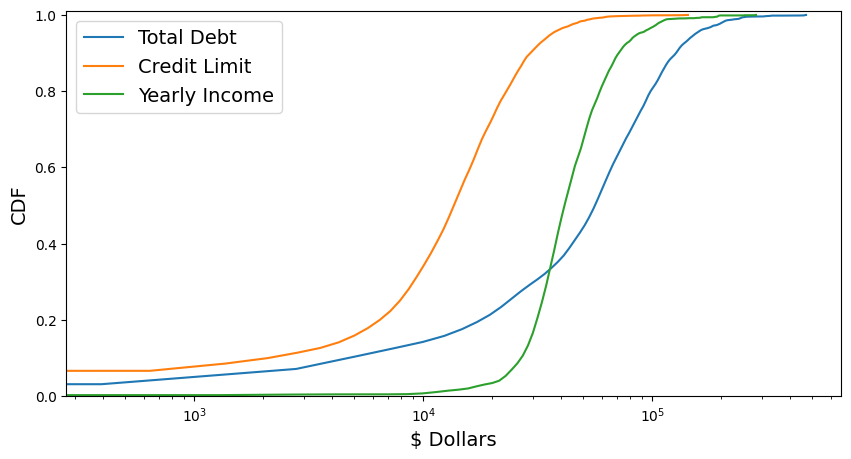

In [85]:
fig,ax = plt.subplots(figsize=(10,5))
# ax.hist(cctrans_aug['Amount'], cumulative=True, label='Transaction Amt', histtype='step')
sns.kdeplot(cctrans_aug.loc[cctrans_aug['Total Debt'] > 1]['Total Debt'], cumulative=True, label='Total Debt')
sns.kdeplot(cctrans_aug.loc[cctrans_aug['Credit Limit'] > 1]['Credit Limit'], cumulative=True, label='Credit Limit')
sns.kdeplot(cctrans_aug.loc[cctrans_aug['Yearly Income - Person'] > 1]['Yearly Income - Person'], cumulative=True, label='Yearly Income')
# ax.set_xlim(xmin=1)
ax.set_xscale('log')
ax.set_xlabel("$ Dollars",fontsize=14)
ax.set_ylabel("CDF", fontsize=14)
ax.legend(fontsize=14)
ax.set_ylim(ymax=1.01)
plt.savefig("/mnt/g/WSL/wsl_ml_figures/ccfraud_debt_income_limit_cdf.png", bbox_inches='tight')

In [ ]:
if plot_:
    cols = ['Amount','Per Capita Income - Zipcode','Total Debt','Credit Limit', 'Yearly Income - Person']
    fig,ax = plt.subplots(figsize=(10,5))
    for cc in cols:
        sns.kdeplot(np.log10(cctrans_aug[cc]), 
                    cumulative=True,
                    label=cc,
                    ax=ax)
    ax.legend()

In [46]:
acct_year = pd.to_datetime(cccards['Acct Open Date'], format="mixed")
print(acct_year.dt.year.max())

2020


In [ ]:
# if plot_:
fig,ax = plt.subplots(figsize=(10,5))
legits = cctrans_aug['Fraud'] == 0
frauds = cctrans_aug['Fraud'] == 1
sns.kdeplot(cctrans_aug['Current Age'][legits], ax=ax, cumulative=True, label='Current Age (legit trans)', color='C0')
sns.kdeplot(cctrans_aug['Current Age'][frauds], ax=ax, cumulative=True, label='Current Age (fraud trans)', ls='--',color='C0')
# sns.kdeplot(ccusers['Retirement Age'], ax=ax, cumulative=True, label='Retirement Age', color='C1')

acct_year = pd.to_datetime(cctrans_aug['Acct Open Date'],format='%m/%Y')
sns.kdeplot(2020-acct_year.dt.year[legits], ax=ax, cumulative=True, label='Account Age (legit trans)', color='C2')
sns.kdeplot(2020-acct_year.dt.year[frauds], ax=ax, cumulative=True, label='Account Age (fraud trans)', color='C2', ls='--')
ax.legend(fontsize=14, location='lower right')
print(ccusers['Current Age'].min())
ax.set_ylabel("CDF", fontsize=14)
ax.set_xlabel("Age (Years)", fontsize=14)
ax.set_ylim(ymax=1.01)
# plt.savefig("

In [ ]:
print(np.sum(cctrans_aug['Merchant City'] == cctrans_aug['City']),
np.sum(cctrans_aug['Merchant State'] == cctrans_aug['State']))

In [ ]:
cctrans_aug['Same City'] = cctrans_aug['Merchant City'] == cctrans_aug['City']
cctrans_aug['Same City'] = cctrans_aug['Same City'].astype('int32')

print("matches city")
matches_city = cctrans_aug.loc[cctrans_aug['Same City'] == 1]
print(Counter(matches_city['Fraud']))
print("doesnt match city")
doesnt_match_city = cctrans_aug.loc[cctrans_aug['Same City'] == 0]
print(Counter(doesnt_match_city['Fraud']))

cctrans_aug['Same State'] = cctrans_aug['Merchant State'] == cctrans_aug['State']
cctrans_aug['Same State'] = cctrans_aug['Same State'].astype('int32')

print("matches state")
matches_state = cctrans_aug.loc[cctrans_aug['Same State'] == 1]
print(Counter(matches_state['Fraud']))
print("doesnt match state")
doesnt_match_state = cctrans_aug.loc[cctrans_aug['Same State'] == 0]
print(Counter(doesnt_match_state['Fraud']))

cctrans_aug['Same Zip'] = cctrans_aug['Zip'].fillna(0).astype('int32') == cctrans_aug['Zipcode'].astype('int32')
cctrans_aug['Same Zip'] = cctrans_aug['Same Zip'].astype('int32')

print("matches zip")
matches_zip = cctrans_aug.loc[cctrans_aug['Same Zip'] == 1]
print(Counter(matches_zip['Fraud']))
print("doesnt match zip")
doesnt_match_zip = cctrans_aug.loc[cctrans_aug['Same Zip'] == 0]
print(Counter(doesnt_match_zip['Fraud']))


matches_city = []
doesnt_match_city = []
matches_state = []
doesnt_match_state = []
matches_zip = []
doesnt_match_zip = [] 


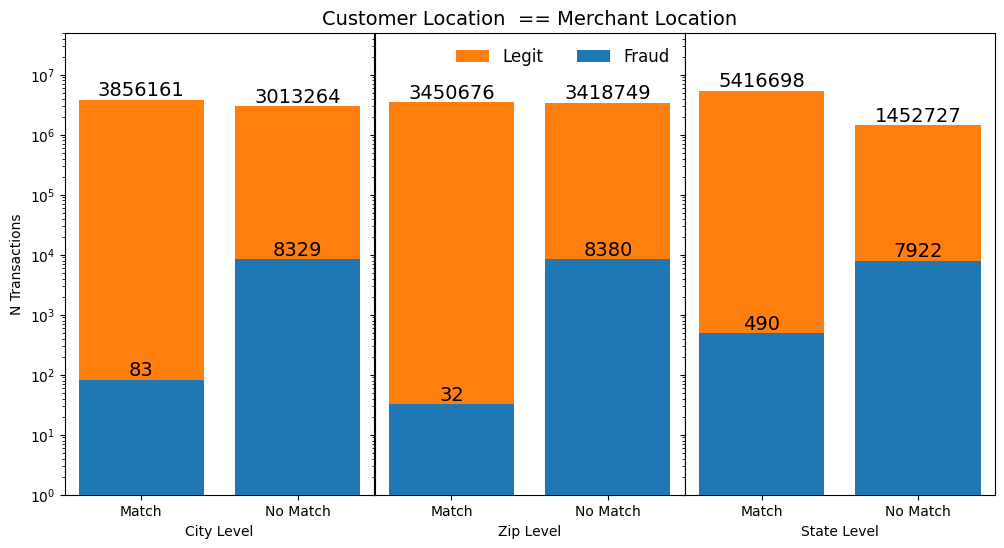

In [38]:
# matches city
mc_legit, mc_fraud  = 3856161, 83
# doesnt match city
dmc_legit, dmc_fraud = 3013264, 8329

# matches zip
mz_legit, mz_fraud = 3450676, 32
# doesnt match zip
dmz_legit, dmz_fraud = 3418749, 8380

# matches state
ms_legit, ms_fraud =  5416698, 490
# doesnt match state
dms_legit, dms_fraud = 1452727, 7922

maxy = 5e7##max([dms_legit, ms_legit, dmz_legit, mz_legit, mc_legit, dmc_legit])

fig,ax = plt.subplots(figsize=(12,6), ncols=3)

clegit = ax[0].bar(['Match','No Match'],[mc_legit,dmc_legit],align='center',label='Legit',color='C1')
cfraud = ax[0].bar(['Match','No Match'],[mc_fraud,dmc_fraud],align='center', label='Fraud',color='C0')
ax[0].set_yscale('log')
ax[0].bar_label(clegit,fmt='%.0f',fontsize=14, label_type='edge')
ax[0].bar_label(cfraud,fmt='%.0f',fontsize=14, label_type='edge')
ax[0].set_xlabel("City Level")
# ax[0].set_ylim(ym/ax=maxy)
ax[0].set_ylim(1, maxy)

zlegit = ax[1].bar(['Match','No Match'],[mz_legit,dmz_legit],align='center',label='Legit',color='C1')
zfraud = ax[1].bar(['Match','No Match'],[mz_fraud,dmz_fraud],align='center', label='Fraud',color='C0')
ax[1].set_yscale('log')
ax[1].bar_label(zlegit,fmt='%.0f',fontsize=14, label_type='edge')
ax[1].bar_label(zfraud,fmt='%.0f',fontsize=14, label_type='edge')
ax[1].set_xlabel("Zip Level")
# ax[2].set_ylim(ymax=maxy)
ax[1].set_ylim(1, maxy)
ax[1].legend(ncols=2,fontsize=12, frameon=False)
ax[1].tick_params(labelleft=False)

slegit = ax[2].bar(['Match','No Match'],[ms_legit,dms_legit],align='center',label='Legit',color='C1')
sfraud = ax[2].bar(['Match','No Match'],[ms_fraud,dms_fraud],align='center', label='Fraud',color='C0')
ax[2].bar_label(slegit,fmt='%.0f',fontsize=14, label_type='edge')
ax[2].bar_label(sfraud,fmt='%.0f',fontsize=14, label_type='edge')
ax[2].set_xlabel("State Level")
ax[2].set_yscale('log')
y1,y2 = ax[2].set_ylim()
ax[2].set_ylim(1, maxy)
ax[2].tick_params(labelleft=False)


ax[1].set_title("Customer Location  == Merchant Location", fontsize=14)
ax[0].set_ylabel("N Transactions")
fig.subplots_adjust(wspace=0.001, hspace=None)
plt.savefig("/mnt/g/WSL/wsl_ml_figures/customer_merchant_location_match_bar.png",bbox_inches='tight',dpi=150)
# plt.close()

In [ ]:
cctrans_aug = cctrans_aug.join(pd.get_dummies(cctrans_aug['Card Brand']).astype('int32'))

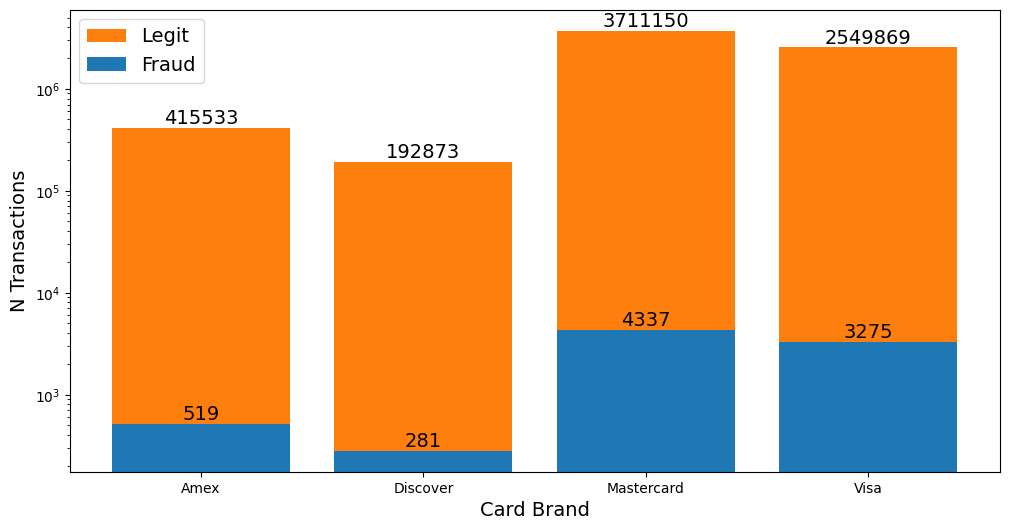

In [40]:
cbrands = ['Amex','Discover', 'Mastercard', 'Visa']

fig,ax = plt.subplots(figsize=(12,6))
for cb in cbrands:
    nlegit = cctrans_aug.loc[(cctrans_aug['Fraud'] == 0)&
                             (cctrans_aug['Card Brand'] == cb)].shape[0]
    nfraud = cctrans_aug.loc[(cctrans_aug['Fraud'] == 1)&
                             (cctrans_aug['Card Brand'] == cb)].shape[0]
    
    bl = ax.bar(cb, nlegit, align='center',color='C1',label='Legit' if cb=='Visa' else '')
    bf = ax.bar(cb, nfraud, align='center', color='C0',label='Fraud' if cb=='Visa' else '')
    ax.bar_label(bl, fontsize=14, fmt='%0.f')
    ax.bar_label(bf, fontsize=14)
ax.legend(fontsize=14, loc='upper left')
ax.set_yscale('log')
ax.set_xlabel("Card Brand", fontsize=14)
ax.set_ylabel("N Transactions", fontsize=14)

plt.savefig("/mnt/g/WSL/wsl_ml_figures/ccfraud_card_brand_bar.png", bbox_inches='tight',dpi=150)

In [ ]:
print(cctrans_aug.sample(2).T)

### feature engineering

In [ ]:
time_bw_open_trans = pd.to_datetime(cctrans_aug[['Year','Month','Day']])- pd.to_datetime(cctrans_aug['Acct Open Date'],format='%m/%Y')
cctrans_aug['Time Since Opening'] = time_bw_open_trans.dt.days/365.25
time_bw_open_trans = []

time_bw_pin_trans = pd.to_datetime(cctrans_aug[['Year','Month','Day']]) - pd.to_datetime(cctrans_aug['Year PIN last Changed'],format='%Y')
cctrans_aug['Time Since PIN Change'] = time_bw_pin_trans.dt.days/365.25
cctrans_aug['Time Since PIN Change'].max()
time_bw_pin_trans = []

cctrans_aug['Time Till Retire'] = cctrans_aug['Retirement Age'] - cctrans_aug['Current Age']
print(cctrans_aug['Time Till Retire'].min(), cctrans_aug['Time Till Retire'].median(), cctrans_aug['Time Till Retire'].max())

cctrans_aug['Zipcode Income Ratio'] = cctrans_aug['Per Capita Income - Zipcode']/cctrans_aug['Yearly Income - Person']
print(cctrans_aug['Zipcode Income Ratio'].min(), cctrans_aug['Zipcode Income Ratio'].median(), cctrans_aug['Zipcode Income Ratio'].max())

cctrans_aug['Debt Income Ratio'] = cctrans_aug['Total Debt'] / cctrans_aug['Yearly Income - Person']
print(cctrans_aug['Debt Income Ratio'].min(), cctrans_aug['Debt Income Ratio'].median(), cctrans_aug['Debt Income Ratio'].max())

time_till_retire = pd.to_datetime(cctrans_aug['Expires'], format='%m/%Y') - pd.to_datetime(cctrans_aug[['Year','Month','Day']])
cctrans_aug['Time Till Expire'] = time_till_retire.dt.days/365.25
time_till_retire = []
print(cctrans_aug['Time Till Expire'].min(), cctrans_aug['Time Till Expire'].median(), cctrans_aug['Time Till Expire'].max())

cctrans_aug['Debt Cards Ratio'] = cctrans_aug['Total Debt'] / cctrans_aug['Num Credit Cards']

In [ ]:
card_type_dummies = pd.get_dummies(cctrans_aug[['Card Type']]).astype('int32')
print(card_type_dummies.loc[cctrans_aug['Fraud']==0].sum(axis=0))
print(card_type_dummies.loc[cctrans_aug['Fraud']==1].sum(axis=0))

gender_dummies = pd.get_dummies(cctrans_aug[['Gender']]).astype('int32')
print(gender_dummies.sum(axis=0))


In [ ]:
cctrans_aug = cctrans_aug.join(card_type_dummies)
card_type_dummies = []

cctrans_aug = cctrans_aug.join(gender_dummies).rename(columns={'Gender_Male':'Man','Gender_Female':'Woman'})
gender_dummies = []

nwoman = cctrans_aug['Woman'] == 1
print(f"N women: {sum(nwoman)}")
print(Counter(cctrans_aug.loc[nwoman]['Fraud']))
nwoman = []

nman = cctrans_aug['Man'] == 1
print(f"N men: {sum(nman)}")
print(Counter(cctrans_aug.loc[nman]['Fraud']))
nman = []

In [ ]:
cctrans_aug.columns

In [ ]:
cctrans_aug['Errors?'] = cctrans_aug['Errors?'].apply(lambda x: 'No Errors' if str(x)=='None' else x)
Counter(cctrans_aug['Errors?'])

no_errors = cctrans_aug.loc[cctrans_aug['Errors?'] == 'No Errors']
no_errors_size = no_errors.shape[0]
no_err_legit = no_errors.loc[no_errors['Fraud'] == 0].shape[0]
no_err_fraud = no_errors.loc[no_errors['Fraud'] == 1].shape[0]
no_errors = []

has_errors = cctrans_aug.loc[cctrans_aug['Errors?'] != 'No Errors']
has_errors_size = has_errors.shape[0]
has_err_legit = has_errors.loc[has_errors['Fraud'] == 0].shape[0]
has_err_fraud = has_errors.loc[has_errors['Fraud'] == 1].shape[0]
has_errors = []

print(f"Ntrans w/o errors: {no_errors_size}, Nfrauds: {no_err_fraud}, Nlegit: {no_err_legit}")
print(f"Ntrans w/ errors: {has_errors_size}, Nfrauds: {has_err_fraud}, Nlegit: {has_err_legit}")

In [ ]:
# Ntrans w/o errors: 6768768, Nfrauds: 8077, Nlegit: 6760691
# Ntrans w/ errors: 109069, Nfrauds: 335, Nlegit: 108734

fig,ax = plt.subplots(figsize=(10,5))

legits = ax.bar(['No Errors','Errors'],[6760691,108734],align='center',label='Legit')
frauds = ax.bar(['No Errors','Errors'],[8077,335],align='center',label='Fraud')
ax.set_yscale('log')
ax.bar_label(legits, fmt='%0.f', fontsize=14)
ax.bar_label(frauds, fmt='%0.f', fontsize=14)
ax.legend(fontsize=14)
ax.set_xlabel("Transaction Errors", fontsize=14)
ax.set_ylabel("N Transactions", fontsize=14)

ax.set_ylim(1,2e7)
plt.savefig("/mnt/g/WSL/wsl_ml_figures/ccfraud_transaction_errors_bar.png",bbox_inches='tight')

In [ ]:
error_type_dummies = pd.get_dummies(cctrans_aug['Errors?']).astype([
cctrans_aug = cctrans_aug.join(error_type_dummies)
error_type_dummies = []

In [ ]:
cctrans_aug['Has Chip'] = cctrans_aug['Has Chip'].apply(lambda x: 1 if x=='Yes' else 0)
chip_type_dummies = pd.get_dummies(cctrans_aug['Use Chip']).astype('int32')
cctrans_aug = cctrans_aug.join(chip_type_dummies)
chip_type_dummies = []

In [ ]:
cctrans_aug['Fraud'] = cctrans_aug['Fraud'].astype('int32')

In [ ]:
print(Counter(cctrans_aug['Card on Dark Web']))
cctrans_aug['Card on Dark Web'] = cctrans_aug['Card on Dark Web'].apply(lambda x: 1 if x=='Yes' else 0)
print(cctrans_aug['Card on Dark Web'].sum())

In [ ]:
cctrans_aug.to_feather("/mnt/g/WSL/downloaded_ml_data/credit_card_dataset_fraud_detect/credit_card_transactions_augmented.feather")
print(cctrans_aug.columns)

In [ ]:
%reset

# Begin Feature Scaling and Model Selection

In [45]:
cols = ['Fraud',
        'Amount','Has Chip','Hour_decimal','FICO Score',#'Cards Issued', 
        'Year','Month','Day','MCC',#'Per Capita Income - Zipcode',
        'Birth Year','Birth Month','Total Debt','Credit Limit', #'Yearly Income - Person',
        'Num Credit Cards', 'Same City', 'Same State', 'Same Zip',
        'Amex','Discover', 'Mastercard', 'Visa', 
        'Time Since Opening', 'Time Since PIN Change', 'Time Till Retire', 'Time Till Expire', 
        'Zipcode Income Ratio', 'Debt Income Ratio', 'Debt Cards Ratio',
        'Card Type_Credit','Card Type_Debit', 'Card Type_Debit (Prepaid)', 
        'Bad CVV','Bad CVV,Insufficient Balance', 'Bad CVV,Technical Glitch',
       'Bad Card Number', 'Bad Card Number,Bad CVV',
       'Bad Card Number,Bad Expiration',
       'Bad Card Number,Insufficient Balance',
       'Bad Card Number,Technical Glitch', 'Bad Expiration',
       'Bad Expiration,Bad CVV', 'Bad Expiration,Insufficient Balance',
       'Bad Expiration,Technical Glitch', 'Bad PIN',
       'Bad PIN,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad Zipcode', 'Bad Zipcode,Insufficient Balance',
       'Bad Zipcode,Technical Glitch', 'Insufficient Balance',
       'Insufficient Balance,Technical Glitch', 'No Errors',
       'Technical Glitch', 
        'Chip Transaction', 'Online Transaction','Swipe Transaction'
       ]
print(len(cols))

56


In [46]:
cctrans_aug = pd.read_feather(
    "/mnt/g/WSL/downloaded_ml_data/credit_card_dataset_fraud_detect/credit_card_transactions_augmented.feather",
    columns=cols)
print(cctrans_aug.shape)
all_frauds = cctrans_aug.Fraud == 1
cctrans_aug_int = cctrans_aug.loc[~all_frauds].sample(3000000 - sum(all_frauds))
cctrans_aug = pd.concat([cctrans_aug_int, cctrans_aug[all_frauds]])
# cctrans_aug.info()
print(cctrans_aug['MCC'].unique().shape)

(6877837, 56)
(109,)


In [47]:
float_cols = []

for cc in cols:
    if cctrans_aug[cc].max() > 1:
        float_cols.append(cc)
print(float_cols)

float_data = cctrans_aug[float_cols].values

# scaler = RobustScaler(quantile_range=(0.3,0.7), unit_variance=True)
# scaler = MinMaxScaler()
scaler = QuantileTransformer(output_distribution='normal')

transformed_float_data = scaler.fit_transform(float_data)

for ii,cc in enumerate(float_cols):
    cctrans_aug[cc] = transformed_float_data[:,ii]

data = cctrans_aug[cols].copy()
print(cols[1:])
# oX = data[cols[1:]].values
cctrans_aug = []

for cc in data.columns:
    # if data[cc].dtype=='float64':
    #     data[cc] = data[cc].astype('float32')
    if data[cc].dtype=='int64':
        data[cc] = data[cc].astype('int32')
data.info()



X = data.loc[:,data.columns!='Fraud']#MinMaxScaler().fit_transform(oX)



y = data['Fraud']
# y = ybin# tf.keras.utils.to_categorical(ybin, num_classes=2)

print(X.shape, y.shape)
# print(data.describe())
data = []

['Amount', 'Hour_decimal', 'FICO Score', 'Year', 'Month', 'Day', 'MCC', 'Birth Year', 'Birth Month', 'Total Debt', 'Credit Limit', 'Num Credit Cards', 'Time Since Opening', 'Time Since PIN Change', 'Time Till Retire', 'Time Till Expire', 'Zipcode Income Ratio', 'Debt Income Ratio', 'Debt Cards Ratio']
['Amount', 'Has Chip', 'Hour_decimal', 'FICO Score', 'Year', 'Month', 'Day', 'MCC', 'Birth Year', 'Birth Month', 'Total Debt', 'Credit Limit', 'Num Credit Cards', 'Same City', 'Same State', 'Same Zip', 'Amex', 'Discover', 'Mastercard', 'Visa', 'Time Since Opening', 'Time Since PIN Change', 'Time Till Retire', 'Time Till Expire', 'Zipcode Income Ratio', 'Debt Income Ratio', 'Debt Cards Ratio', 'Card Type_Credit', 'Card Type_Debit', 'Card Type_Debit (Prepaid)', 'Bad CVV', 'Bad CVV,Insufficient Balance', 'Bad CVV,Technical Glitch', 'Bad Card Number', 'Bad Card Number,Bad CVV', 'Bad Card Number,Bad Expiration', 'Bad Card Number,Insufficient Balance', 'Bad Card Number,Technical Glitch', 'Bad E

In [48]:
trainX, checkX, trainy, checky = train_test_split(X, y, train_size=0.5, stratify=y)

testX, validX, testy, validy = train_test_split(checkX, checky, train_size=0.5, stratify=checky)

print(trainX.shape,trainy.shape, testX.shape, testy.shape, validX.shape, validy.shape)

UPSAMPLE = True

if UPSAMPLE:
    ada = RandomOverSampler(random_state=666, shrinkage=1e-20, sampling_strategy=0.1)
    X_res, y_res = ada.fit_resample(trainX, trainy)
    print(X_res.shape, y_res.shape)
    
    cw_train = class_weight.compute_class_weight(
                        class_weight='balanced',
                        classes=np.unique(y),
                        y=y_res if UPSAMPLE else trainy
    )
    cw_trdict = {0: cw_train[0], 1: cw_train[1]}

assert sum(y_res == 0) == sum(trainy == 0)
print(X_res.columns)

bu_cw_train = class_weight.compute_class_weight(
                    class_weight='balanced',
                    classes=np.unique(y),
                    y=trainy
)
bu_cw_trdict = {0: bu_cw_train[0], 1: bu_cw_train[1]}

cw_test = class_weight.compute_class_weight(
                    class_weight='balanced',
                    classes=np.unique(y),
                    y=testy
)
cw_tsdict = {0: cw_test[0], 1: cw_test[1]}
sw_test = class_weight.compute_sample_weight(
                    class_weight=cw_tsdict,
                    y=testy
)

cw_valid = class_weight.compute_class_weight(
                    class_weight='balanced',
                    classes=np.unique(y),
                    y=validy
)
cw_vdict = {0: cw_valid[0], 1: cw_valid[1]}

sw_valid = class_weight.compute_sample_weight(
                    class_weight=cw_vdict,
                    y=validy
)


def swish(x):
    return (K.sigmoid(x)*x)

get_custom_objects().update({'swish':Activation(swish)})


def plot_confusion_matrix(cm, classes,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm_whole = cm
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    # plt.colorbar(label='Fraction')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    lbls = np.array(['TP','FP','FN','TN']).reshape(2,2)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, lbls[i,j]+'\n'+format(cm[i, j], fmt)+f"\n({cm_whole[i,j]})",
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black",
                fontsize=14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)


def find_loss_function_minima(x,y):
    # ypeak = np.argmax(y)
    # xpeak = x[ypeak]
    # x_after_peak = x[x > xpeak]
    # y_after_peak = 
    for ii in range(len(x)-2):
        cntr = ii+1
        if (y[cntr] < y[ii]) & (y[cntr] < y[ii+2]):
            return (x[cntr],y[cntr])
            

print(np.array(['TP','FP','FN','TN']).reshape(2,2))


(1500000, 55) (1500000,) (750000, 55) (750000,) (750000, 55) (750000,)
(1645373, 55) (1645373,)
Index(['Amount', 'Has Chip', 'Hour_decimal', 'FICO Score', 'Year', 'Month',
       'Day', 'MCC', 'Birth Year', 'Birth Month', 'Total Debt', 'Credit Limit',
       'Num Credit Cards', 'Same City', 'Same State', 'Same Zip', 'Amex',
       'Discover', 'Mastercard', 'Visa', 'Time Since Opening',
       'Time Since PIN Change', 'Time Till Retire', 'Time Till Expire',
       'Zipcode Income Ratio', 'Debt Income Ratio', 'Debt Cards Ratio',
       'Card Type_Credit', 'Card Type_Debit', 'Card Type_Debit (Prepaid)',
       'Bad CVV', 'Bad CVV,Insufficient Balance', 'Bad CVV,Technical Glitch',
       'Bad Card Number', 'Bad Card Number,Bad CVV',
       'Bad Card Number,Bad Expiration',
       'Bad Card Number,Insufficient Balance',
       'Bad Card Number,Technical Glitch', 'Bad Expiration',
       'Bad Expiration,Bad CVV', 'Bad Expiration,Insufficient Balance',
       'Bad Expiration,Technical Glitch'

In [6]:
print(trainy.sum(), testy.sum(), validy.sum(), trainy.sum() + testy.sum() + validy.sum(), trainy.sum()/trainy.shape[0],testy.sum()/testy.shape[0],validy.sum()/validy.shape[0])
print(y_res.sum(), y_res.sum()/y_res.shape[0])

4206 2103 2103 8412 0.002804 0.002804 0.002804
149579 0.09090886990366318


In [ ]:
pca = PCA(n_components=2)
pca.fit(trainX)
projection = pca.fit_transform(trainX)
if UPSAMPLE:
    projectres = pca.transform(X_res)

In [ ]:
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(*projection[trainy == 0].T, marker='o',s=1, color='cyan',alpha=0.1,zorder=-1)
ax.scatter(*projection[trainy == 1].T, marker='+',s=1, color='black',alpha=1,zorder=3)
if UPSAMPLE:
    ax.scatter(*projectres[y_res==1].T, marker='o', s=1e-1,color='red', alpha=0.3,zorder=2)

#### Building Dense NN to identify frauds (abandoned)

In [ ]:
best_params = {'dense_dropout1':0.2,# 0.2860454842621313, 
    'dense_dropout2': 0.2, #0.25266694878122964, 
    'l1_reg_values': 3.5e-5, #0.0005593064199340701, 
    'l2_reg_values': 3.5e-5, #0.00021065085194335904, 
    'learning_rate': 2.5e-5, #8.901278205149715e-05, 
    'units': 1024}

def build_model():
    mdl = Sequential()
    mdl.add(Dense(trainX.shape[1] , input_shape=(trainX.shape[1],)))
    mdl.add(Activation('relu'))

    mdl.add(Dense(64))
    mdl.add(Activation('relu'))
    
    mdl.add(Dense(128))
    mdl.add(Activation('relu'))
    mdl.add(Dropout(best_params['dense_dropout1']))

    mdl.add(Dense(256))
    mdl.add(Activation('relu'))
    mdl.add(Dropout(best_params['dense_dropout1']))
    kernel_regs = tf.keras.regularizers.l1_l2(
                        l1=best_params['l1_reg_values'], 
                        l2=best_params['l2_reg_values'])
    
    mdl.add(Dense(best_params['units']))
    mdl.add(Activation('relu'))
    mdl.add(Dropout(best_params['dense_dropout1']))

    # mdl.add(BatchNormalization())
    
    mdl.add(Dense(best_params['units']))
    mdl.add(Activation('relu'))
    mdl.add(Dropout(best_params['dense_dropout2']))

    # mdl.add(Dense(512))
    # mdl.add(Activation('relu'))
    # mdl.add(Dropout(0.25))
    
    mdl.add(Dense(256, kernel_regularizer=kernel_regs))
    mdl.add(Activation('relu'))
    mdl.add(Dropout(best_params['dense_dropout2']))
    
    mdl.add(Dense(128, kernel_regularizer=kernel_regs))
    mdl.add(Activation('relu'))
    mdl.add(Dropout(best_params['dense_dropout2']))

    mdl.add(Dense(32, kernel_regularizer=kernel_regs))
    mdl.add(Activation('relu'))
    
    mdl.add(Dense(8, kernel_regularizer=kernel_regs))
    mdl.add(Activation('relu'))
    
    mdl.add(Dense(1, activation='swish'))

    return mdl


In [ ]:
tf.keras.backend.clear_session()
model = build_model()
model.summary()

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    # metrics=['Accuracy'],
    weighted_metrics=['Accuracy']
)

In [ ]:
# print(np.unique(trainy))
      
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    #Reduce learning rate when a metric has stopped improving.
    monitor="val_Accuracy",
    factor=0.95,
    patience=3,
    verbose=0,
    mode="auto",
    min_delta=0.001,
    cooldown=2,
    min_lr=1e-8
)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_Accuracy',
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
    mode='max'
)

# X_res,y_res = [],[]
mdlhist = model.fit(
            X_res if UPSAMPLE else trainX, 
            y_res if UPSAMPLE else trainy, 
            batch_size=512,
            shuffle=True,
            epochs=30,
            validation_data=(validX, validy, sw_valid),
            validation_batch_size=512,
            verbose=1,
            class_weight=cw_trdict,
            callbacks=[earlystop, reduce_lr]
           )

In [ ]:
model.evaluate(testX, testy,
               batch_size=1024,
               sample_weight=sw_test)

preds = model.predict(testX, 
                     batch_size=1024)
print(preds.shape)
ypreds = np.round(preds).squeeze()
print(testy.shape, ypreds.shape)
cm = confusion_matrix(testy, ypreds)
print(cm[:2,:2])

fig,ax = plt.subplots(figsize=(10,5))

plot_confusion_matrix(cm[:2,:2], classes=['Legit','Fraud'])

In [ ]:
pre_score = precision_score(testy, ypreds, sample_weight=sw_test)
rec_score = recall_score(testy, ypreds, sample_weight=sw_test)
acc_score = accuracy_score(testy, ypreds, sample_weight=sw_test)
classify_report = classification_report(testy, ypreds, sample_weight=sw_test)
print(classify_report)

In [ ]:
def model_tuner(hp):

    dropout_dense1 = hp.Float("dense_dropout1",
                             min_value = 0.05,
                             max_value = 0.25)

    dropout_dense2 = hp.Float("dense_dropout2",
                             min_value = 0.05,
                             max_value = 0.25)
    
    l1_num = hp.Float("l1_reg_values", 
                      min_value=1e-5, 
                      max_value=1e-3)
    
    l2_num = hp.Float("l2_reg_values", 
                      min_value=1e-5, 
                      max_value=1e-3)

    lr_val = hp.Float("learning_rate", 
                      min_value=1e-7, 
                      max_value=1e-4)

    layer_unit = hp.Choice('units', [512, 1024, 2048, 4096])
    
    mdl = Sequential()
    mdl.add(Dense(trainX.shape[1] , input_shape=(trainX.shape[1],)))
    mdl.add(Activation('relu'))

    mdl.add(Dense(64))
    mdl.add(Activation('relu'))
    
    mdl.add(Dense(128))
    mdl.add(Activation('relu'))
    mdl.add(Dropout(dropout_dense1))

    mdl.add(Dense(256))
    mdl.add(Activation('relu'))
    mdl.add(Dropout(dropout_dense1))
    kernel_regs = tf.keras.regularizers.l1_l2(l1=l1_num, l2=l2_num)
    
    mdl.add(Dense(layer_unit))
    mdl.add(Activation('relu'))
    mdl.add(Dropout(dropout_dense1))

    mdl.add(BatchNormalization())
    
    mdl.add(Dense(layer_unit))
    mdl.add(Activation('relu'))
    mdl.add(Dropout(dropout_dense2))

    # mdl.add(Dense(512))
    # mdl.add(Activation('relu'))
    # mdl.add(Dropout(0.25))
    
    mdl.add(Dense(256, kernel_regularizer=kernel_regs))
    mdl.add(Activation('relu'))
    mdl.add(Dropout(dropout_dense2))
    
    mdl.add(Dense(128,kernel_regularizer=kernel_regs))
    mdl.add(Activation('relu'))
    mdl.add(Dropout(dropout_dense2))

    mdl.add(Dense(32))
    mdl.add(Activation('relu'))
    
    mdl.add(Dense(16))
    mdl.add(Activation('relu'))
    
    mdl.add(Dense(1, activation='sigmoid'))

    mdl.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        optimizer=Adam(learning_rate=lr_val),
        # metrics=['Accuracy'],
        weighted_metrics=['Accuracy']
    )
    
    return mdl
    
tf.keras.backend.clear_session()

trial_number = 25
tuner = kt.RandomSearch(
    model_tuner,
    objective='val_Accuracy',
    max_trials = trial_number, #Number of trials
    overwrite=True,
    project_name="fraud_detect",
    directory="/mnt/g/WSL/tmp/tb")

tuner.search(trainX, trainy,
            batch_size=1024,
            epochs=10,
            validation_data=(validX, validy, csw),
            validation_batch_size=1024,
            verbose=1,
            class_weight=cw,)

In [ ]:
besthp = tuner.get_best_hyperparameters()
print(besthp[0].values)

# {'dense_dropout1': 0.2860454842621313, 
    # 'dense_dropout2': 0.25266694878122964, 
    # 'l1_reg_values': 0.0005593064199340701, 
    # 'l2_reg_values': 0.00021065085194335904, 
    # 'learning_rate': 8.901278205149715e-05, 
    # 'units': 1024}

In [ ]:
bmdl = tuner.get_best_models()[0]

In [ ]:
bmdl.evaluate(testX, testy,
               batch_size=1024,
               sample_weight=cswt)

preds = bmdl.predict(testX, 
                     batch_size=1024)

ypreds = np.round(preds)
cm = confusion_matrix(testy, ypreds)
print(cm)
plot_confusion_matrix(cm, classes=['Legit','Fraud'])

# Building autoencoder NN to sus out frauds and tuning with random search

In [ ]:
def swish(x):
    return (K.sigmoid(x)*x)

get_custom_objects().update({'swish':Activation(swish)})

def model_tuner(hp):

    l1_num = hp.Float("l1_reg_values", 
                      min_value=1e-5, 
                      max_value=1e-3)
    
    l2_num = hp.Float("l2_reg_values", 
                      min_value=1e-5, 
                      max_value=1e-3)

    lr_val = hp.Float("learning_rate", 
                      min_value=1e-5, 
                      max_value=1e-3)
    
    input = tf.keras.layers.Input(shape=(trainX.shape[1],))

    kernel_regs = tf.keras.regularizers.l1_l2(l1=l1_num, l2=l2_num)
    
    encoder_mdl = Sequential()
    encoder_mdl.add(Dense(56, kernel_regularizer=kernel_regs))
    encoder_mdl.add(BatchNormalization())
    encoder_mdl.add(Activation("relu"))

    encoder_mdl.add(Dense(32, kernel_regularizer=kernel_regs))
    # encoder_mdl.add(BatchNormalization())
    encoder_mdl.add(Activation("relu"))
    # encoder_mdl.add(Dropout(dropout_dense1))

    encoder_mdl.add(Dense(16, kernel_regularizer=kernel_regs))
    encoder_mdl.add(Activation("relu"))
    

    encoder_mdl.add(Dense(8, kernel_regularizer=kernel_regs))
    encoder_mdl.add(Activation("relu"))

    encoder_mdl = encoder_mdl(input)
    
    ############################################
    
    decoder_mdl = Sequential()

    decoder_mdl.add(Dense(8))
    decoder_mdl.add(Activation("relu"))
    
    decoder_mdl.add(Dense(16))
    decoder_mdl.add(Activation("relu"))

    decoder_mdl.add(Dense(32))
    decoder_mdl.add(Activation("relu"))
    
    decoder_mdl.add(Dense(56))
    decoder_mdl.add(Activation("relu"))
    
    decoder_mdl.add(Dense(trainX.shape[1]))
    decoder_mdl.add(Activation("swish"))

    decoder_mdl = decoder_mdl(encoder_mdl)
    
    autoencoder_mdl = tf.keras.Model(inputs=input, outputs=decoder_mdl)

    autoencoder_mdl.compile(
                    optimizer=Adam(learning_rate=lr_val),
                    loss='mae',
                    weighted_metrics=['mae']
    )
    
    return autoencoder_mdl

tf.keras.backend.clear_session()

trial_number = 100
tuner = kt.RandomSearch(
    model_tuner,
    objective='val_mae',
    max_trials = trial_number, #Number of trials
    overwrite=True,
    # beta=3.,
    # num_initial_points=12,
    project_name="fraud_detect_ae",
    directory="/mnt/g/WSL/tmp/tb")

tuner.search(
        X_res if UPSAMPLE else trainX, 
        y_res if UPSAMPLE else trainy,
        class_weight=cw_trdict,
        batch_size=1024,
        validation_data=(validX, validy,sw_valid),
        validation_batch_size=1024,
        epochs=10,
        verbose=1,
        shuffle=True
)
besthp = tuner.get_best_hyperparameters()
print(besthp[0].values)


In [ ]:
bmdl = tuner.get_best_models()[0]
preds = bmdl.predict(testX, batch_size=1024)
preds_loss = tf.keras.losses.mae(testX, preds)

fig,ax = plt.subplots(figsize=(10,5))
kdeplt = sns.kdeplot(preds_loss, ax=ax)
line = kdeplt.lines[0]
kdex, kdey = line.get_data()
print(min(kdex),max(kdex),min(kdey),max(kdey))
ax.axvline(0.5, ls='--')

# mask = (kdex>0.6) & (kdex<1.0)
# threshold = kdex[mask][np.argmin(kdey[mask])]
threshold,ymin = find_loss_function_minima(kdex,kdey)
ax.axvline(threshold, color='gray',ls='--')
ax.axhline(ymin, color='gray',ls='--')
print(threshold)
print(preds.shape)
ax.set_xlabel("prediction loss")
# plt.savefig("/mnt/g/WSL/wsl_ml_figures/autoencoder_prediction_loss.png",bbox_inches='tight')

fraud_preds = np.zeros_like(preds_loss)
fraud_preds[preds_loss > threshold] = 1

fig,ax = plt.subplots(figsize=(10,5))

cm = confusion_matrix(testy, fraud_preds)

print(cm)
plot_confusion_matrix(cm, classes=['Legit','Fraud'])
# plt.savefig("/mnt/g/WSL/wsl_ml_figures/autoencoder_confusion_matrix.png",bbox_inches='tight')
pre_score = precision_score(testy, fraud_preds, sample_weight=sw_test)
rec_score = recall_score(testy, fraud_preds, sample_weight=sw_test)
acc_score = accuracy_score(testy, fraud_preds, sample_weight=sw_test)
classify_report = classification_report(testy, fraud_preds, sample_weight=sw_test)
print(classify_report)

### Run longer training on best params model

In [8]:


# Best Value So Far |Hyperparameter
# 0.00059274        |l1_reg_values
# 0.00049178        |l2_reg_values
# 0.00045635        |learning_rate
def build_autoencoder():

    input = tf.keras.layers.Input(shape=(trainX.shape[1],))

    kernel_regs = tf.keras.regularizers.l1_l2(l1=0.00059274, l2=0.00049178)
    
    encoder_mdl = Sequential()

    encoder_mdl.add(Dense(56, kernel_regularizer=kernel_regs))
    encoder_mdl.add(Activation("relu"))

    encoder_mdl.add(Dense(32, kernel_regularizer=kernel_regs))
    encoder_mdl.add(Activation("relu"))

    encoder_mdl.add(Dense(16, kernel_regularizer=kernel_regs))
    encoder_mdl.add(Activation("relu"))

    encoder_mdl.add(Dense(8, kernel_regularizer=kernel_regs))
    encoder_mdl.add(Activation("relu"))
    

    encoder_mdl = encoder_mdl(input)
    
    ############################################
    
    decoder_mdl = Sequential()

    decoder_mdl.add(Dense(8))
    decoder_mdl.add(Activation("relu"))

    decoder_mdl.add(Dense(16))
    decoder_mdl.add(Activation("relu"))

    decoder_mdl.add(Dense(32))
    decoder_mdl.add(Activation("relu"))
    
    decoder_mdl.add(Dense(56))
    decoder_mdl.add(Activation("relu"))
    
    decoder_mdl.add(Dense(trainX.shape[1]))
    decoder_mdl.add(Activation("swish"))

    decoder_mdl = decoder_mdl(encoder_mdl)
    
    autoencoder_mdl = tf.keras.Model(inputs=input, outputs=decoder_mdl)

    return autoencoder_mdl


In [9]:
tf.keras.backend.clear_session()

autoencoder_mdl = build_autoencoder()

metric = 'mae'
autoencoder_mdl.compile(
                optimizer=Adam(learning_rate=1e-4),
                loss=metric,
                weighted_metrics=[metric]
)

autoencoder_mdl.summary()

2023-11-13 18:34:04.946752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-13 18:34:05.063248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-13 18:34:05.063517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-13 18:34:05.065361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-13 18:34:05.065559: I tensorflow/compile

In [12]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    #Reduce learning rate when a metric has stopped improving.
    monitor=f"val_{metric}",
    factor=0.95,
    patience=3,
    verbose=0,
    mode="auto",
    min_delta=0.01,
    cooldown=2,
    min_lr=1e-8
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor=f'val_{metric}',
    patience=5,
    start_from_epoch=15,
    restore_best_weights=True,
    mode='min'
)
no_fraud = trainy == 0
aehist = autoencoder_mdl.fit(
                        X_res if UPSAMPLE else trainX, 
                        y_res if UPSAMPLE else trainy,
                        class_weight=cw_trdict,
                        batch_size=1024,
                        validation_data=(validX, validy, sw_valid),
                        validation_batch_size=1024,
                        epochs=30,
                        verbose=1,
                        shuffle=True,
                        callbacks=[earlystop],
                        
                            )

Epoch 1/30


2023-11-13 18:34:08.637057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-13 18:34:08.697827: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f81cd811940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-13 18:34:08.697862: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-11-13 18:34:08.714003: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 18:34:08.786963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-13 18:34:08.945737: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

1607/1607 [==============================] - 21s 12ms/step - loss: 0.5907 - mae: 0.3184 - val_loss: 0.2565 - val_mae: 0.1023
Epoch 2/30
1607/1607 [==============================] - 19s 12ms/step - loss: 0.2002 - mae: 0.0866 - val_loss: 0.1679 - val_mae: 0.0792
Epoch 3/30
1607/1607 [==============================] - 19s 12ms/step - loss: 0.1448 - mae: 0.0682 - val_loss: 0.1309 - val_mae: 0.0636
Epoch 4/30
1607/1607 [==============================] - 19s 12ms/step - loss: 0.1170 - mae: 0.0556 - val_loss: 0.1158 - val_mae: 0.0594
Epoch 5/30
1607/1607 [==============================] - 19s 12ms/step - loss: 0.1030 - mae: 0.0503 - val_loss: 0.1093 - val_mae: 0.0599
Epoch 6/30
1607/1607 [==============================] - 19s 12ms/step - loss: 0.0942 - mae: 0.0474 - val_loss: 0.1024 - val_mae: 0.0578
Epoch 7/30
1607/1607 [==============================] - 19s 12ms/step - loss: 0.0885 - mae: 0.0456 - val_loss: 0.0999 - val_mae: 0.0587
Epoch 8/30
1607/1607 [==============================] - 19s

Text(0.5, 0, 'Epoch')

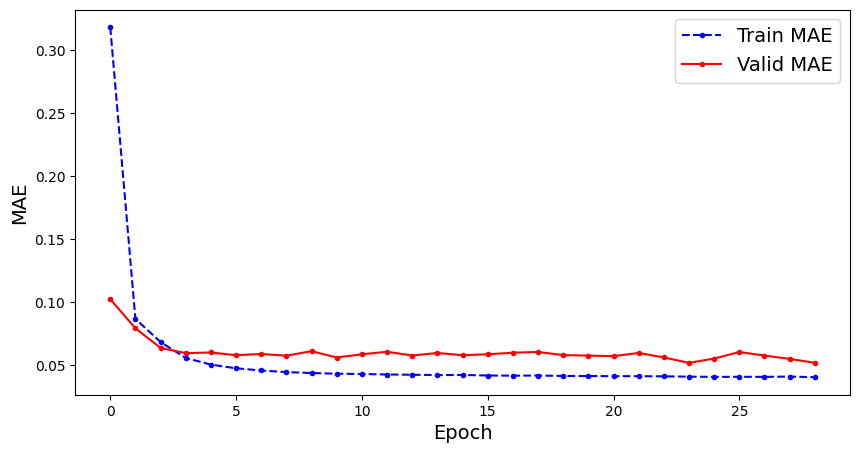

In [27]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(aehist.epoch, aehist.history['mae'], marker='.',ls='--', color='blue', label='Train MAE')
ax.plot(aehist.epoch, aehist.history['val_mae'], marker='.',ls='-', color='red', label='Valid MAE')

ax.legend(fontsize=14)
ax.set_ylabel("MAE", fontsize=14)
ax.set_xlabel("Epoch", fontsize=14)
# ax.plot(aehist.epoch, aehist.history['loss'], ls='--', color='red')
# ax.plot(aehist.epoch, aehist.history['val_loss'], ls='-', color='red')

  9/733 [..............................] - ETA: 4s - loss: 0.0862 - mae: 0.0543   

2023-11-21 14:58:39.529013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


733/733 [==============================] - 2s 2ms/step
0.8738323576860934
(750000, 55)
[[700656  47241]
 [   110   1993]]
              precision    recall  f1-score   support

           0      0.947     0.937     0.942 374999.999996665
           1      0.938     0.948     0.943 375000.0000000009

    accuracy                          0.942 749999.9999966659
   macro avg      0.942     0.942     0.942 749999.9999966659
weighted avg      0.942     0.942     0.942 749999.9999966659



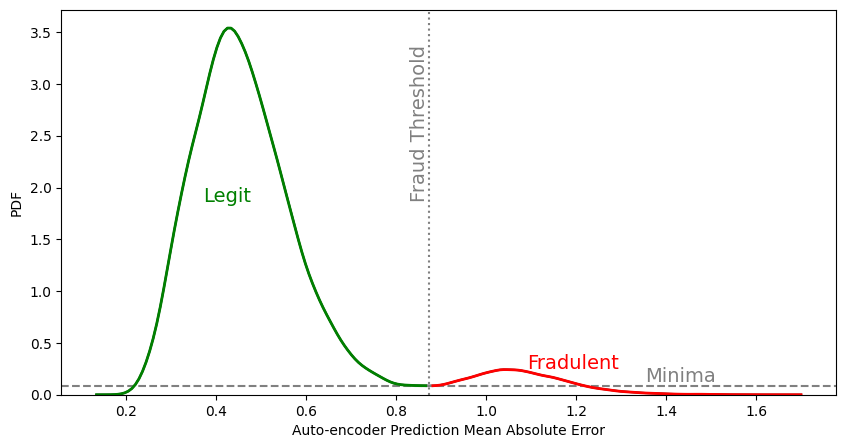

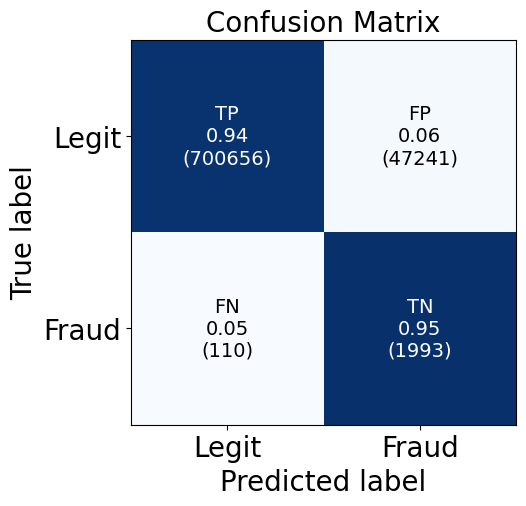

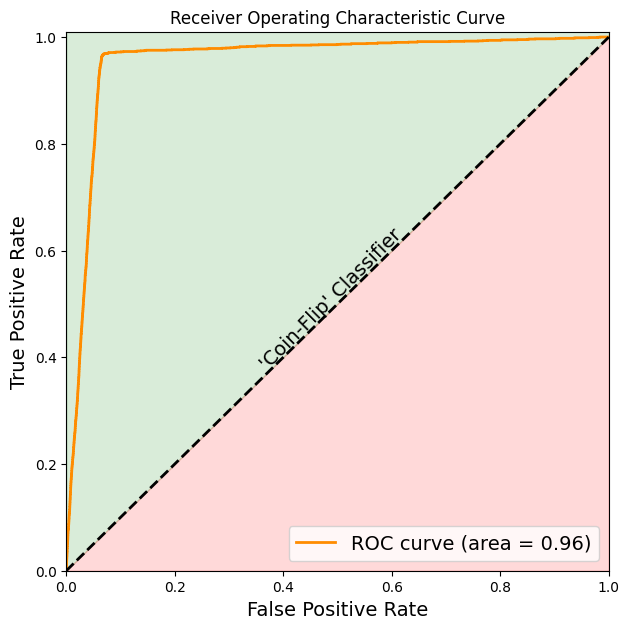

In [49]:
autoencoder_mdl = tf.keras.models.load_model("/mnt/g/WSL/models/ae_ccfraud_ds4a")
eval = autoencoder_mdl.evaluate(testX, testy, 
                                batch_size=1024,
                                sample_weight=sw_test)
preds = autoencoder_mdl.predict(testX, batch_size=1024)
preds_loss = tf.keras.losses.mae(testX, preds)


# loss_threshold = np.percentile(preds_loss, 98)

fig,ax = plt.subplots(figsize=(10,5))
kdeplt = sns.kdeplot(preds_loss, ax=ax, color='black')
line = kdeplt.lines[0]
kdex, kdey = line.get_data()
# print(min(kdex),max(kdex),min(kdey),max(kdey))
# ax.axvline(0.5, ls='--')

# mask = (kdex>0.6) & (kdex<1.0)
# threshold = kdex[mask][np.argmin(kdey[mask])]
threshold,ymin = find_loss_function_minima(kdex,kdey)

legit_mask = kdex < threshold
fraud_mask = kdex > threshold

legitx,legity = kdex[legit_mask], kdey[legit_mask]
fraudx, fraudy = kdex[fraud_mask], kdey[fraud_mask]

legit_peak, legit_cent = np.max(legity), legitx[np.argmax(legity)] 
fraud_peak, fraud_cent = np.max(fraudy), fraudx[np.argmax(fraudy)]

ax.axvline(threshold, color='gray',ls=':')
ax.axhline(ymin, color='gray',ls='--')

ax.plot(legitx, legity,ls='-',color='green',lw=2)
ax.plot(fraudx, fraudy, ls='-',color='red', lw=2)

x1,x2 = ax.set_xlim()
y1,y2 = ax.set_ylim()
ax.text(legit_cent, 0.5*(y2-y1), 'Legit', horizontalalignment='center', color='green', fontsize=14)
ax.text(fraud_cent + 0.05*fraud_cent, fraud_peak + 0.05*fraud_peak, 'Fradulent',fontsize=14, 
        horizontalalignment='left', color='red')
ax.text(threshold-0.05*threshold,0.5*(y2-y1), 'Fraud Threshold',
        horizontalalignment='left',
        verticalalignment='bottom',
        rotation=90,
       color='gray', fontsize=14)

ax.text(x2-0.15*x2, ymin+0.05*ymin,
        'Minima',
        horizontalalignment='right',
        verticalalignment='bottom',
        color='gray', fontsize=14
       )
ax.set_ylabel("PDF")
print(threshold)
print(preds.shape)
ax.set_xlabel("Auto-encoder Prediction Mean Absolute Error")
plt.savefig("/mnt/g/WSL/wsl_ml_figures/autoencoder_prediction_loss.png",bbox_inches='tight', dpi=150)

fraud_preds = np.zeros_like(preds_loss)
fraud_preds[preds_loss > threshold] = 1

fig,ax = plt.subplots(figsize=(10,5))

cm = confusion_matrix(testy, fraud_preds)

SAVE_MODEL_ = False
if SAVE_MODEL_:
    autoencoder_mdl.save("/mnt/g/WSL/models/ae_ccfraud_ds4a")

print(cm)
plot_confusion_matrix(cm, classes=['Legit','Fraud'])
plt.savefig("/mnt/g/WSL/wsl_ml_figures/autoencoder_confusion_matrix.png",bbox_inches='tight', dpi=150)

pre_score = precision_score(testy, fraud_preds, sample_weight=sw_test)
rec_score = recall_score(testy, fraud_preds, sample_weight=sw_test)
acc_score = accuracy_score(testy, fraud_preds, sample_weight=sw_test)
classify_report = classification_report(testy, fraud_preds, sample_weight=sw_test, digits=3)
print(classify_report)

### plot roc-auc curve

fpr, tpr, thresholds = roc_curve(testy, preds_loss)
roc_auc = auc(fpr, tpr)

fig,ax = plt.subplots(figsize=(7,7))
lw = 2
ax.plot(fpr, tpr, color='darkorange',
         lw=lw, label=f'ROC curve (area = {roc_auc:0.2f})')
ax.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
ax.fill_between([0,1],[0,1],[1.01,1.01],color='green',alpha=0.15,zorder=-1)
ax.fill_between([0,1],[0,1],[0.0,0.0],color='red',alpha=0.15,zorder=-1)

ax.text(0.35,0.37, "'Coin-Flip' Classifier",
        horizontalalignment='left',
        verticalalignment='bottom',
        rotation=45, fontsize=14)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.01])
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right", fontsize=14)

plt.savefig("/mnt/g/WSL/wsl_ml_figures/autoencoder_roc_auc_plot.png",bbox_inches='tight', dpi=150)


In [110]:
# precision    recall  f1-score   support

# 0       0.95      0.94      0.95 374999.999996665
# 1       0.94      0.95      0.95 375000.0000000009